In [51]:
import sys

sys.path.append('..')
from config import *

from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import StateGraph, END
from langchain_core.prompts import PromptTemplate
from typing import TypedDict, Optional, Dict, Any

In [39]:
# 先定义用于保存到word的函数
import os
from docx import Document
from docx.enum.text import WD_ALIGN_PARAGRAPH


def parse_md_table(md: str):
    """
    解析 Markdown 表格：返回表头和数据行
    """
    lines = [l.strip() for l in md.strip().splitlines() if l.strip()]
    header = [c.strip() for c in lines[0].strip('|').split('|')]
    data_lines = lines[2:]

    rows = [
        [c.strip() for c in line.strip('|').split('|')]
        for line in data_lines
    ]
    return header, rows


def append_table(doc: Document, header, rows, table_title: str):
    """
    在文档最后插入表名 + 表格
    """
    # 插入表名（标题）
    p = doc.add_paragraph(table_title)
    p.alignment = WD_ALIGN_PARAGRAPH.CENTER
    p.runs[0].bold = True

    # 插入表格
    table = doc.add_table(rows=1 + len(rows), cols=len(header))
    table.style = "Table Grid"

    # 写表头
    header_cells = table.rows[0].cells
    for i, text in enumerate(header):
        header_cells[i].text = text

    # 写数据行
    for r_i, row in enumerate(rows, start=1):
        row_cells = table.rows[r_i].cells
        for c_i, text in enumerate(row):
            row_cells[c_i].text = text


def append_table_to_docx(doc_path: str, md_table: str, table_title: str, output_path: str = None):
    """
    如果 docx 文件不存在 → 创建新文档
    如果 docx 文件存在 → 在末尾插入表名 + 表格

    参数：
        doc_path (str): 原始 docx 路径（自动判断是否存在）
        md_table (str): Markdown 表格字符串
        table_title (str): 表名，例如 "表 1 学生成绩"
        output_path (str): 输出路径（默认覆盖原文件）
    """
    # 如果文件不存在则新建
    if not os.path.exists(doc_path):
        doc = Document()
    else:
        doc = Document(doc_path)

    # 解析 Markdown 表格
    header, rows = parse_md_table(md_table)

    # 在文末追加表格
    append_table(doc, header, rows, table_title)

    # 保存
    if output_path is None:
        output_path = doc_path

    doc.save(output_path)
    return output_path

# 分开输出逻辑模型和物理模型
## 逻辑模型

In [3]:
BIG_PROMPT = r"""
你是数据库逻辑模型文档生成器。根据我提供的 MySQL 建表 SQL（CREATE TABLE），为每张表生成一张逻辑模型 Markdown 表格。

输出要求：
- 语言：中文
- 只输出一张 Markdown 表格，不要输出标题、解释说明或其他文字
- 不要输出任何代码块标记（不要输出 ```）
- 不要增删字段，不要省略字段
- 每张表仅输出一张逻辑模型表格；如果 SQL 中有多张表，则按顺序依次输出多张表格（表格之间空一行）
- 有 COMMENT 用 COMMENT 作为中文名；没有就根据字段名简单推断，看不出就留空
- 当内容不确定或无法从 SQL 明确判断时，对应单元格留空，不要填「待确认」「—」等占位词

逻辑模型表的表头固定为：

| 序号 | 逻辑属性名 | 逻辑数据类型 | 是否必填 | 备注 |

填写规则：
- 序号：从 1 开始，按字段在表中的顺序依次递增
- 逻辑属性名：字段的中文名，优先使用 COMMENT；无 COMMENT 时可根据字段名简单推断，看不出就留空
- 逻辑数据类型：归类为「字符串 / 整数 / 数值 / 日期时间 / 布尔 / 枚举」等，按最接近类型填写，不确定则留空
- 是否必填：主键或 NOT NULL = 是，其它 = 否
- 备注：如「逻辑主键」「系统生成」等，不确定就留空

下面是需要你转换的建表 SQL：
{sql_ddl}
"""
prompt = PromptTemplate(
    input_variables=["sql_ddl"],
    template=BIG_PROMPT
)

llm = ChatOpenAI(model="qwen-plus")

chain = prompt | llm

In [ ]:
sql_ddl = """
          create table address
          (
              address_id  varchar(256) not null
                  primary key,
              customer_id varchar(256) null,
              is_default  tinyint(1)                          null,
              first_name  varchar(512) null,
              phone       varchar(512) null,
              last_name   varchar(512) null,
          ) comment '客户信息表' row_format = DYNAMIC; \
          """

result = chain.invoke({"sql_ddl": sql_ddl})

In [ ]:
from IPython.display import Markdown, display

display(Markdown(result.content))

## 物理模型

In [30]:
BIG_PROMPT = r"""
你是数据库物理模型文档生成器。根据我提供的 MySQL 建表 SQL（CREATE TABLE），为每张表生成一张物理模型 Markdown 表格。

输出要求：
- 语言：中文
- 只输出 Markdown 表格，不要输出标题、解释说明或其他文字
- 不要输出任何代码块标记（不要输出 ```）
- 不要增删字段，不要省略字段
- 每张表仅输出一张物理模型表格；如果 SQL 中有多张表，则按顺序依次输出多张表格（表格之间空一行）
- 有 COMMENT 用 COMMENT 作为字段注释；没有 COMMENT 时可根据字段名简单推断中文含义，看不出就留空
- 当内容不确定或无法从 SQL 明确判断时，对应单元格留空，不要填「待确认」「—」等占位词

物理模型表头固定为：

| 序号 | 字段 | 数据类型 | 数据长度 | 是否为空 | 字段注释 |

填写规则：
- 序号：从 1 开始，按字段在表中的顺序依次递增
- 字段：直接填写 SQL 中的字段名
- 数据类型：按 SQL 中的数据类型原样填写（不含括号中的长度），如 VARCHAR、INT、BIGINT、DATETIME、DECIMAL 等
- 数据长度：
  - VARCHAR(20) → 写 20
  - CHAR(10) → 写 10
  - DECIMAL(10,2) → 写 10,2
  - 其它带括号的类型按括号内内容填写
  - 无长度或精度时留空
- 是否为空：
  - NOT NULL → 填「否」
  - 其他情况 → 填「是」
- 字段注释：
  - 优先使用 COMMENT 文本
  - 无 COMMENT 时，可根据字段名简单推断含义，如 id → 主键ID，created_at → 创建时间
  - 看不出含义则保持为空

下面是需要你转换的建表 SQL：
{sql_ddl}
"""
prompt = PromptTemplate(
    input_variables=["sql_ddl"],
    template=BIG_PROMPT
)

llm = ChatOpenAI(model="qwen-plus")

chain = prompt | llm

In [ ]:
sql_ddl = """
          create table address
          (
              address_id  varchar(256) not null
                  primary key,
              customer_id int4 null,
              is_default  tinyint(1)                          null,
              first_name  varchar(256) null,
              phone       varchar(512) null,
              last_name   varchar(512) null,
          ) comment '客户信息表' row_format = DYNAMIC; \
          """

result = chain.invoke({"sql_ddl": sql_ddl})

In [ ]:
from IPython.display import Markdown, display

display(Markdown(result.content))

## 保存

In [ ]:
md_table = result.content

append_table_to_docx(
    doc_path="report.docx",
    md_table=md_table,
    table_title="表 1",
)

# 解析文件，并批量生成对应表格

navicat导出的数据文件如下
```
-- ----------------------------
-- Table structure for access_token
-- ----------------------------
DROP TABLE IF EXISTS "public"."access_token";
CREATE TABLE "public"."access_token" (
  "id" varchar(64) COLLATE "pg_catalog"."default" NOT NULL,
  "expire_time" timestamp(6),
  "is_forever" char(1) COLLATE "pg_catalog"."default",
  "is_active" char(1) COLLATE "pg_catalog"."default",
  "create_by" varchar(64) COLLATE "pg_catalog"."default" DEFAULT ''::character varying,
  "create_time" timestamp(6) DEFAULT date_trunc('milliseconds'::text, pg_systimestamp()),
  "update_by" varchar(64) COLLATE "pg_catalog"."default" DEFAULT ''::character varying,
  "update_time" timestamp(6),
  "remark" varchar(500) COLLATE "pg_catalog"."default",
  "point1" point
)
WITH (orientation=ROW, storage_type=USTORE)
;
COMMENT ON COLUMN "public"."access_token"."id" IS '主键';
COMMENT ON COLUMN "public"."access_token"."expire_time" IS '过期时间';
COMMENT ON COLUMN "public"."access_token"."is_forever" IS '是否永久有效';
COMMENT ON COLUMN "public"."access_token"."is_active" IS '是否可用';
COMMENT ON COLUMN "public"."access_token"."create_by" IS '创建者';
COMMENT ON COLUMN "public"."access_token"."create_time" IS '创建时间';
COMMENT ON COLUMN "public"."access_token"."update_by" IS '更新者';
COMMENT ON COLUMN "public"."access_token"."update_time" IS '更新时间';
COMMENT ON COLUMN "public"."access_token"."remark" IS '备注';
COMMENT ON TABLE "public"."access_token" IS '授权码';

-- ----------------------------
-- Table structure for app_message
-- ----------------------------
DROP TABLE IF EXISTS "public"."app_message";
CREATE TABLE "public"."app_message" (
  "id" int8 NOT NULL DEFAULT nextval('app_message_id_seq'::regclass),
  "type" int4,
  "business_id" int8,
  "publish_at" timestamp(6)
)
WITH (orientation=ROW, storage_type=USTORE)
;
COMMENT ON COLUMN "public"."app_message"."id" IS '主键id';
COMMENT ON COLUMN "public"."app_message"."type" IS '类型';
COMMENT ON COLUMN "public"."app_message"."business_id" IS '对应消息id-某类型id';
COMMENT ON COLUMN "public"."app_message"."publish_at" IS '发生时间';
COMMENT ON TABLE "public"."app_message" IS '站内信表';
```

## 解析 Navicat 多表 SQL 内容，提取各表 SQL 片段

In [63]:
import re


def extract_tables_to_dict(sql_text: str) -> dict:
    """
    从 Navicat 多表 SQL 内容中解析出各表全部 SQL 片段（含 DROP / CREATE / COMMENT）
    返回: {table_name: sql_block}
    """

    # 以 Navicat 分隔线进行分段，每个段对应一个 table
    parts = re.split(r'-- ----------------------------', sql_text)
    table_dict = {}

    for part in parts:
        part = part.strip()
        if not part:
            continue

        # 匹配 CREATE TABLE "schema"."table"
        table_name_match = re.search(
            r'CREATE TABLE\s+"[^"]+"\."([^"]+)"',
            part,
            flags=re.IGNORECASE
        )

        if not table_name_match:
            continue

        table_name = table_name_match.group(1)

        # 保留完整 SQL（DROP、CREATE、COMMENT 全部包含）
        table_dict[table_name] = part.strip()

    return table_dict

In [64]:
path = r'D:\桌面\public.sql'
with open(path, "r", encoding="utf-8") as f:
    sql_str = f.read()

tables = extract_tables_to_dict(sql_str)

## 构建Agent

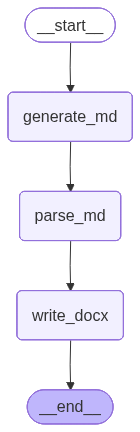

In [65]:
class State(TypedDict):
    sql_ddl: str
    title: str
    md_table: Optional[str]
    header: Optional[list]
    rows: Optional[list]
    doc_path: str


llm = ChatOpenAI(model="qwen-plus")

BIG_PROMPT = r"""
你是数据库逻辑模型文档生成器。根据我提供的 MySQL 建表 SQL（CREATE TABLE），为每张表生成一张逻辑模型 Markdown 表格。

输出要求：
- 语言：中文
- 只输出一张 Markdown 表格，不要输出标题、解释说明或其他文字
- 不要输出任何代码块标记（不要输出 ```）
- 不要增删字段，不要省略字段
- 每张表仅输出一张逻辑模型表格；如果 SQL 中有多张表，则按顺序依次输出多张表格（表格之间空一行）
- 有 COMMENT 用 COMMENT 作为中文名；没有就根据字段名简单推断，看不出就留空
- 当内容不确定或无法从 SQL 明确判断时，对应单元格留空，不要填「待确认」「—」等占位词

逻辑模型表的表头固定为：

| 序号 | 逻辑属性名 | 逻辑数据类型 | 是否必填 | 备注 |

填写规则：
- 序号：从 1 开始，按字段在表中的顺序依次递增
- 逻辑属性名：字段的中文名，优先使用 COMMENT；无 COMMENT 时可根据字段名简单推断，看不出就留空
- 逻辑数据类型：归类为「字符串 / 整数 / 数值 / 日期时间 / 布尔 / 枚举」等，按最接近类型填写，不确定则留空
- 是否必填：主键或 NOT NULL = 是，其它 = 否
- 备注：如「逻辑主键」「系统生成」等，不确定就留空

下面是需要你转换的建表 SQL：
{sql_ddl}
"""
prompt = PromptTemplate(
    input_variables=["sql_ddl"],
    template=BIG_PROMPT
)


def generate_md_table_node(state: State):
    result = prompt | llm
    output = result.invoke({"sql_ddl": state["sql_ddl"]})
    state["md_table"] = output.content
    return state


def parse_md_table(md: str):
    lines = [l.strip() for l in md.strip().splitlines() if l.strip()]
    header = [c.strip() for c in lines[0].strip('|').split('|')]
    data_lines = lines[2:]

    rows = [
        [c.strip() for c in line.strip('|').split('|')]
        for line in data_lines
    ]
    return header, rows


def parse_md_node(state: State):
    h, r = parse_md_table(state["md_table"])
    state["header"] = h
    state["rows"] = r
    return state


def append_table(doc, header, rows, table_title):
    p = doc.add_paragraph(table_title)
    p.alignment = WD_ALIGN_PARAGRAPH.CENTER
    p.runs[0].bold = True

    table = doc.add_table(rows=1 + len(rows), cols=len(header))
    table.style = "Table Grid"

    header_cells = table.rows[0].cells
    for i, text in enumerate(header):
        header_cells[i].text = text

    for r_i, row in enumerate(rows, start=1):
        row_cells = table.rows[r_i].cells
        for c_i, text in enumerate(row):
            row_cells[c_i].text = text


def write_docx_node(state: State):
    doc_path = state['doc_path']

    if not os.path.exists(doc_path):
        doc = Document()
    else:
        doc = Document(doc_path)

    append_table(doc, state["header"], state["rows"], state["title"])
    doc.save(doc_path)

    state["doc_path"] = doc_path
    return state


graph = StateGraph(State)

graph.add_node("generate_md", generate_md_table_node)
graph.add_node("parse_md", parse_md_node)
graph.add_node("write_docx", write_docx_node)

graph.set_entry_point("generate_md")
graph.add_edge("generate_md", "parse_md")
graph.add_edge("parse_md", "write_docx")
graph.add_edge("write_docx", END)

workflow = graph.compile()

display(Image(workflow.get_graph().draw_mermaid_png()))

## 执行程序

In [66]:
tables_need = {
    "yjmx_request_data": "预警模型请求"
}

total = len(tables_need)
count = 0

for table_en, table_ch in tables_need.items():
    count += 1

    res = workflow.invoke({
        "sql_ddl": tables.get(table_en),
        "title": f"{table_en}({table_ch})",
        "doc_path": "report1.docx"})

    print(f"已处理表：{table_en}（{count}/{total}）")

已处理表：yjmx_request_data（1/1）
